# California Housing Price Prediction

This notebook demonstrates an end-to-end regression pipeline to predict
`median_house_value` using the California Housing dataset.

The workflow includes:
- Data loading and exploratory analysis
- Feature preprocessing (scaling & one-hot encoding)
- Model comparison (Linear Regression vs Random Forest)
- Evaluation using MAE, RMSE, and R²
- Visualization of predictions and feature importance

The goal is to compare a baseline linear model with a non-linear ensemble
approach and analyze performance trade-offs.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [ ]:
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
df.isna().sum().sort_values(ascending=False).head(10)

,0
total_bedrooms,207
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [ ]:
df_fe = df.copy()

df_fe["rooms_per_household"] = df["total_rooms"]/df["households"]
df_fe["bedrooms_ratio"] = df["total_bedrooms"]/df["total_rooms"]
df_fe["population_per_household"] = df["population"]/df["households"]

num_cols = df_fe.select_dtypes(include=[np.number]).columns
df_fe[num_cols] = df_fe[num_cols].fillna(df_fe[num_cols].median())

df_fe.isna().sum().sort_values(ascending=False).head(13)


,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


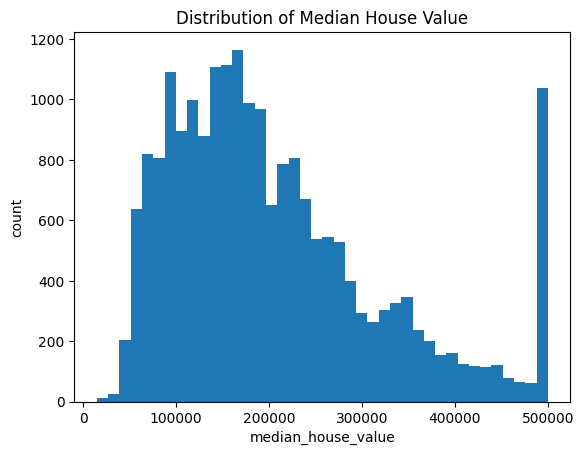

In [ ]:
import os
os.makedirs("visuals", exist_ok=True)

plt.figure()
plt.hist(df_fe["median_house_value"], bins=40)
plt.title("Distribution of Median House Value")
plt.xlabel("median_house_value")
plt.ylabel("count")
plt.savefig("visuals/target_distribution.png", dpi=200, bbox_inches="tight")
plt.show()


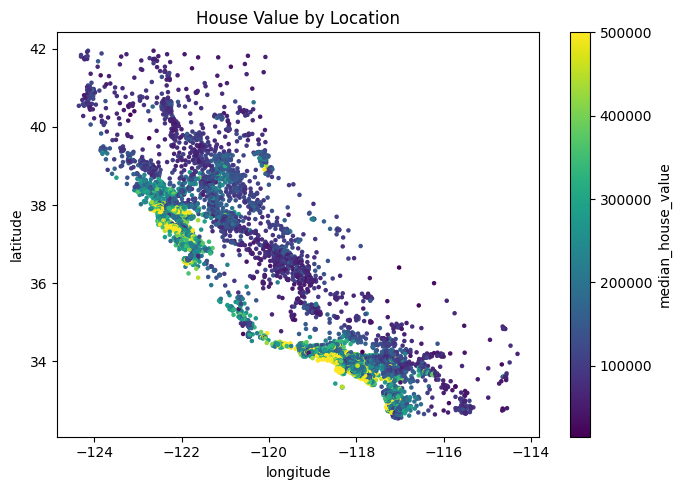

In [ ]:

plt.figure(figsize=(7,5))
plt.scatter(df_fe["longitude"], df_fe["latitude"], s=5, c=df_fe["median_house_value"])
plt.colorbar(label="median_house_value")
plt.title("House Value by Location")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()
plt.savefig("visuals/location_price.png", dpi=200, bbox_inches="tight")
plt.show()

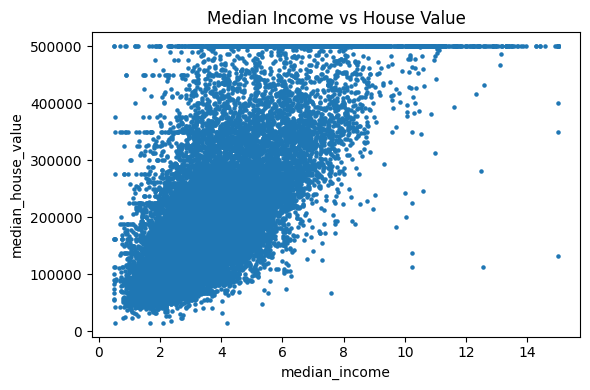

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df_fe["median_income"], df_fe["median_house_value"], s=5)
plt.title("Median Income vs House Value")
plt.xlabel("median_income")
plt.ylabel("median_house_value")
plt.tight_layout()
plt.savefig("visuals/income_vs_price.png", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
y = df_fe["median_house_value"]
X = df_fe.drop(columns=["median_house_value"])
X.shape, y.shape

((20640, 12), (20640,))

In [ ]:
"median_house_value" in X.columns

False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((16512, 12), (4128, 12))

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cat_cols = ["ocean_proximity"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)


In [ ]:
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 49645.511217853615
RMSE: 69126.81294720496
R2: 0.6353416110859854


In [ ]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("RF MAE:", rf_mae)
print("RF RMSE:", rf_rmse)
print("RF R2:", rf_r2)

RF MAE: 31755.928397125328
RF RMSE: 49448.89098956273
RF R2: 0.8134023147964006


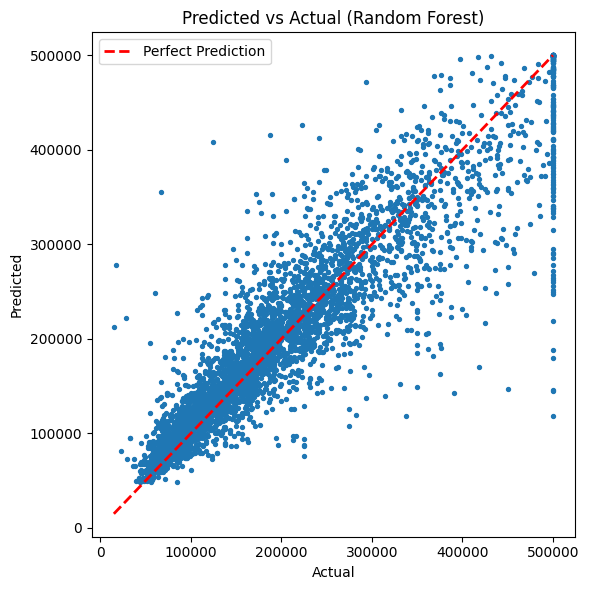

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, rf_pred, s=8)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Perfect Prediction"
)
plt.legend()

plt.title("Predicted vs Actual (Random Forest)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()

plt.savefig("visuals/pred_vs_actual_rf.png", dpi=200, bbox_inches="tight")
plt.show()

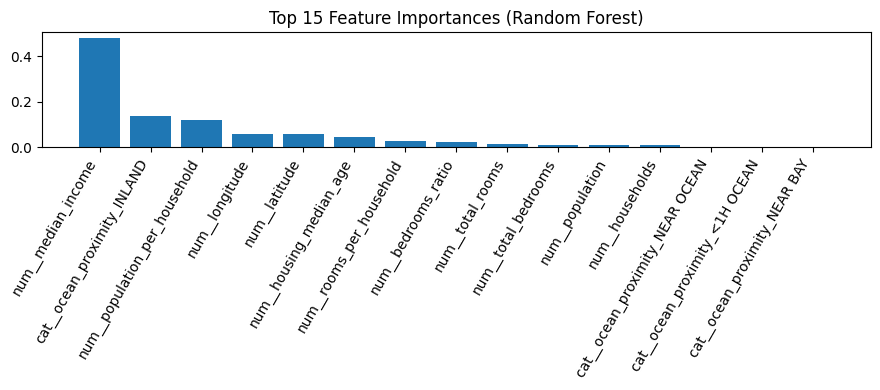

,0
num__median_income,0.480941
cat__ocean_proximity_INLAND,0.138622
num__population_per_household,0.120948
num__longitude,0.057794
num__latitude,0.056596
num__housing_median_age,0.044083
num__rooms_per_household,0.026045
num__bedrooms_ratio,0.024387
num__total_rooms,0.012611
num__total_bedrooms,0.011960


In [ ]:
feature_names = rf_model.named_steps["preprocess"].get_feature_names_out()

rf_est = rf_model.named_steps["regressor"]

importances = pd.Series(rf_est.feature_importances_, index=feature_names).sort_values(ascending=False)

top = importances.head(15)

plt.figure(figsize=(9,4))
plt.bar(top.index, top.values)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()

plt.savefig("visuals/feature_importance_rf.png", dpi=200, bbox_inches="tight")
plt.show()

top
